In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask
get_global("cache_dir")
from facebook_hateful_memes_detector.models import MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
# data = get_datasets(data_dir="../data/", train_text_transform=None, train_image_transform=None, 
#                     test_text_transform=None, test_image_transform=None, 
#                     cache_images = True, use_images = False, dev=False, test_dev=True,
#                     keep_original_text=False, keep_original_image=False, 
#                     keep_processed_image=True, keep_torchvision_image=False,)

# texts = list(data["train"].text.values) + list(data["test"].text.values) + list(data["dev"].text.values)
# pd.DataFrame({"texts": texts}).to_csv("text.csv", header=False, index=False)


In [3]:
initial_model = "/home/ahemf/cache/distilbert-mlm"
model_type = "distilbert-base-uncased"
output_model = "/home/ahemf/cache/distilbert"
batch_size = 256

tokenizer = AutoTokenizer.from_pretrained(model_type)
tokenizer.sep_token
tokenizer.sep_token_id
tokenizer.special_tokens_map

choice_probas = {
    "keyboard": 0.1,
    "char_substitute": 0.0,
    "char_insert": 0.1,
    "char_swap": 0.0,
    "ocr": 0.0,
    "char_delete": 0.1,
    "split": 0.2,
    "stopword_insert": 0.2,
    "word_join": 0.2,
    "word_cutout": 0.2,
    "text_rotate": 0.0,
    "sentence_shuffle": 0.5,
    "one_third_cut": 0.5,
    "half_cut": 0.1
}

preprocess_text = TextAugment([0.0, 0.5, 0.5],
                                choice_probas,
                                fasttext_file="wiki-news-300d-1M-subword.bin")



texts = pd.read_csv("text.csv", header=None)[0].values

def save(model, tokenizer, output_dir):
    import os
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

scheduler_init_fn = get_cosine_schedule_with_warmup()


'[SEP]'

102

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Coherence
- Jumbled vs non jumbled
- Is first half swapped with 2nd half

Pick stored Model /home/ahemf/cache/distilbert-mlm Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.540432 LR = 0.00003333



Epoch =  2 Loss = 0.400341 LR = 0.00006667



Epoch =  3 Loss = 0.345282 LR = 0.00010000



Epoch =  4 Loss = 0.314531 LR = 0.00009505



Epoch =  5 Loss = 0.345072 LR = 0.00008117



Epoch =  6 Loss = 0.292616 LR = 0.00006113



Epoch =  7 Loss = 0.287671 LR = 0.00003887



Epoch =  8 Loss = 0.284559 LR = 0.00001883



Epoch =  9 Loss = 0.252809 LR = 0.00000495



Epoch =  10 Loss = 0.252250 LR = 0.00000000



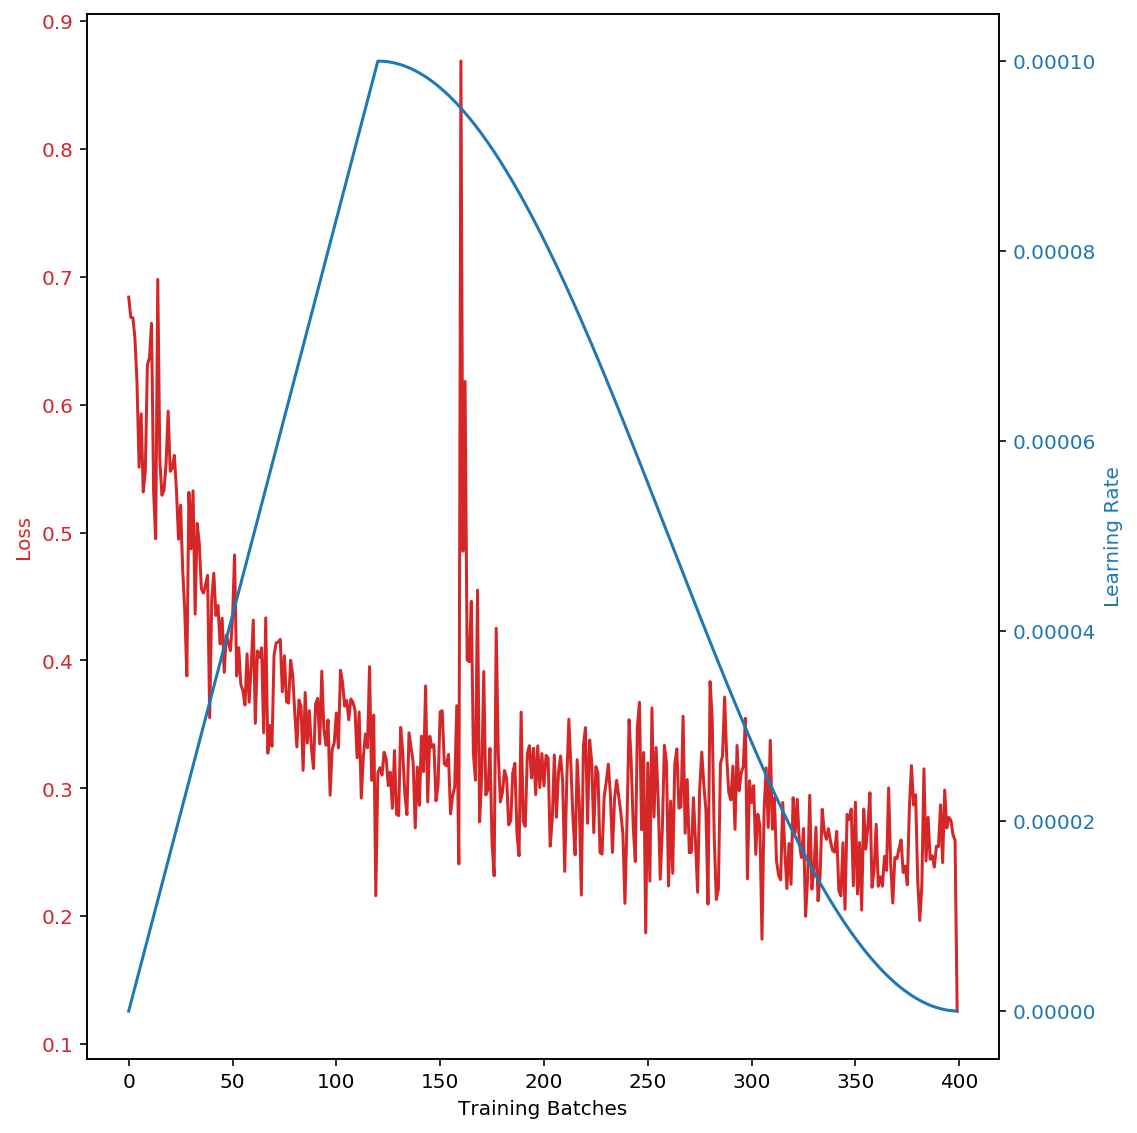

Proba       Preds    
         min   max   min max
Labels                      
0      0.000 0.992     0   1
1      0.001 1.000     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.081,"[0.9190633296966553, 0.08093671500682831]",0,0,0.716,"[0.2842530310153961, 0.7157469391822815]",1,0,0.127,"[0.8725103735923767, 0.1274895966053009]",0,0
1,0.108,"[0.892375111579895, 0.10762491077184677]",0,0,0.968,"[0.03188898786902428, 0.968110978603363]",1,1,0.520,"[0.4804786741733551, 0.5195213556289673]",1,0
2,0.011,"[0.9891186952590942, 0.010881332680583]",0,0,0.005,"[0.9953904151916504, 0.004609572701156139]",0,0,0.001,"[0.9993500113487244, 0.0006499982555396855]",0,0
3,0.003,"[0.9971990585327148, 0.0028009270317852497]",0,0,0.600,"[0.4004562497138977, 0.5995438098907471]",1,0,0.698,"[0.30187633633613586, 0.6981236934661865]",1,1
4,0.042,"[0.9576951861381531, 0.04230480268597603]",0,0,0.070,"[0.9299510717391968, 0.07004895806312561]",0,0,0.067,"[0.9331572651863098, 0.06684277951717377]",0,0


scores =  {'map': '0.8881', 'acc': '0.8829', 'auc': '0.9559'}


([0.8880814873862628, 0.8829, 0.9558817843334584],
 (array([0.96108781, 0.70780693]),
  array([0.88046647, 0.89038305]),
  array([0.91901238, 0.78866631]),
  array([7546, 2454])))

In [12]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random
class CoherenceTextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
        
    def __getitem__(self, item):
        text = self.texts[item]
        if random.random() < 0.25:
            return Sample({"text": text, "label": 1})
        else:
            tarr = text.split()
            wc = len(tarr)
            if random.random() < 0.5:
                random.shuffle(tarr)
            else:
                fh = tarr[:int(wc/2)]
                lh = tarr[int(wc/2):]
                tarr = lh + fh
            return Sample({"text": " ".join(tarr), "label": 0})
            
    
    def __len__(self):
        return len(self.texts)
    
model_name = initial_model # output_model + "-mlm"

optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

dataset = CoherenceTextDataset(texts)

epochs = 10

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.0,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=1,
                              n_decoders=0,
                              n_tokens_in=88,
                              n_tokens_out=8,
                              featurizer="transformer",
                              model=model_name,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)



Autocast =  True Epochs =  5 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.263498 LR = 0.00006667



Epoch =  2 Loss = 0.246631 LR = 0.00009505



Epoch =  3 Loss = 0.220954 LR = 0.00006113



Epoch =  4 Loss = 0.190813 LR = 0.00001883



Epoch =  5 Loss = 0.164950 LR = 0.00000000



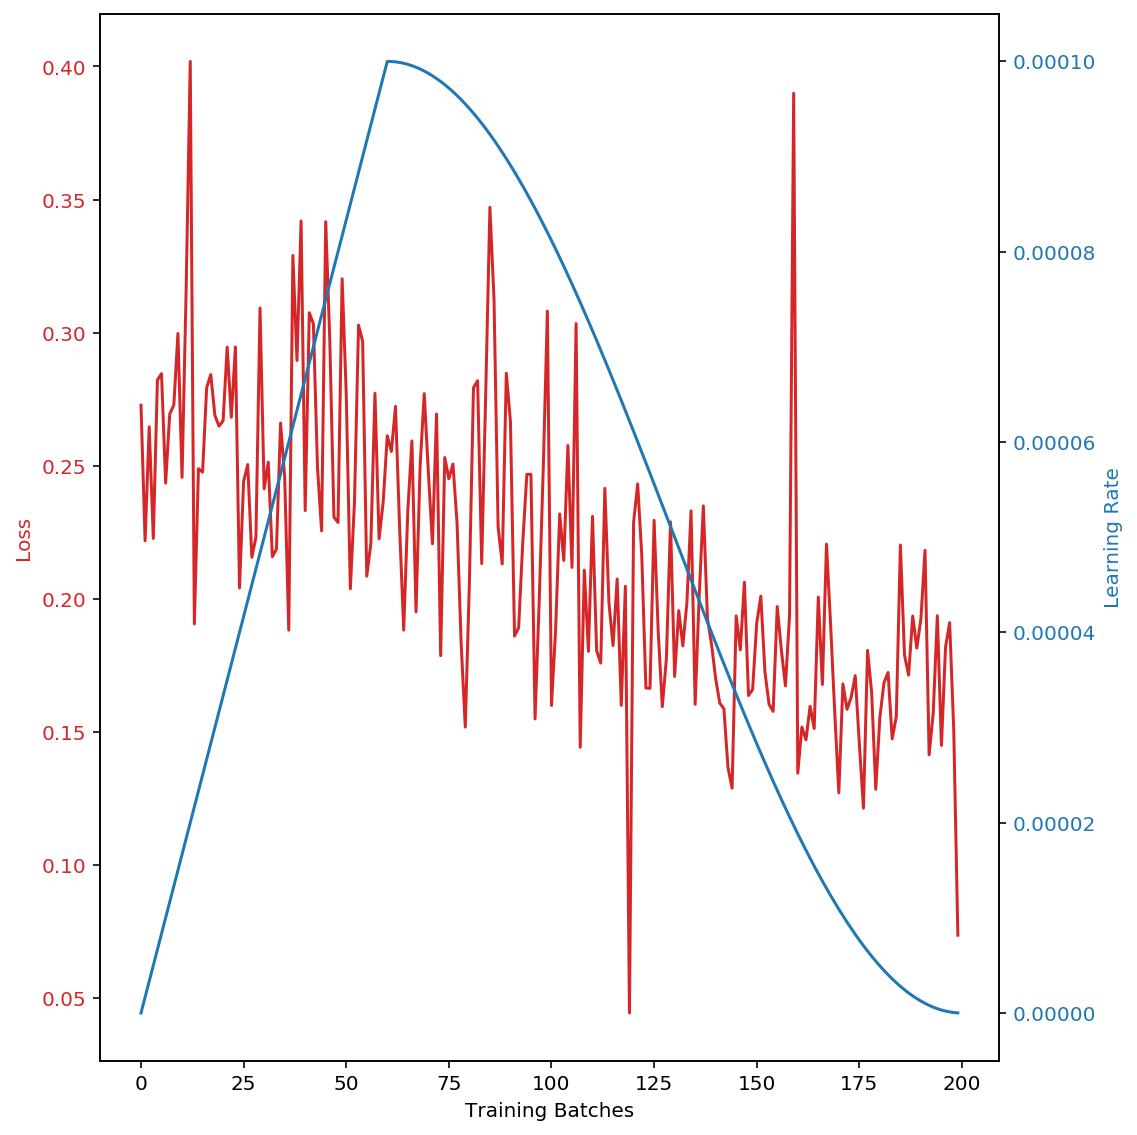

Proba       Preds    
         min   max   min max
Labels                      
0      0.000 0.996     0   1
1      0.002 1.000     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.988,"[0.012007351033389568, 0.9879926443099976]",1,1,0.000,"[0.9998775720596313, 0.00012243444507475942]",0,0,0.788,"[0.21194645762443542, 0.788053572177887]",1,1
1,0.995,"[0.004573863931000233, 0.9954261183738708]",1,1,0.000,"[0.9999629259109497, 3.7052966945338994e-05]",0,0,0.000,"[0.9999750852584839, 2.487648634996731e-05]",0,0
2,0.030,"[0.9700985550880432, 0.029901403933763504]",0,0,0.025,"[0.9751071333885193, 0.02489279769361019]",0,0,0.156,"[0.8437020182609558, 0.156297966837883]",0,0
3,0.996,"[0.003721708431839943, 0.9962782263755798]",1,1,0.000,"[0.9999366998672485, 6.327425944618881e-05]",0,0,0.029,"[0.970520555973053, 0.029479406774044037]",0,0
4,0.033,"[0.9667260646820068, 0.03327393904328346]",0,0,0.078,"[0.9223425984382629, 0.07765743881464005]",0,0,0.001,"[0.999464213848114, 0.0005357805639505386]",0,0


scores =  {'map': '0.9609', 'acc': '0.9398', 'auc': '0.9845'}


([0.9608578336766925, 0.9398, 0.9845106933218086],
 (array([0.97523651, 0.84921764]),
  array([0.94296476, 0.93063133]),
  array([0.95882916, 0.88806248]),
  array([7434, 2566])))

In [13]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}
epochs = 5
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)


In [14]:

save(model.model, model.tokenizer, output_dir=output_model + "-cor")


# Augmented/Masked Text same as Original Text - RMSE

In [17]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params



In [18]:

from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel
class BertVectorizer(torch.nn.Module):
    def __init__(self, model, sequence_length, pooled_multiplier):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model)
        self.sequence_length = sequence_length
        self.pooled_multiplier = pooled_multiplier
        
    def forward(self, texts):
        tokenizer = self.tokenizer
        n_tokens_in = self.sequence_length
        converted_texts = tokenizer.batch_encode_plus(texts, add_special_tokens=True, pad_to_max_length=True, max_length=n_tokens_in, truncation=True)
        input_ids, attention_mask = converted_texts["input_ids"], converted_texts["attention_mask"]
        input_ids, attention_mask = torch.tensor(input_ids).to(get_device()), torch.tensor(attention_mask).to(get_device())
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs[0]
        pooled_output = outputs[1].unsqueeze(1)
        pooled_output = pooled_output * self.pooled_multiplier
        output = torch.cat((pooled_output, last_hidden_states), 1)
        return output
        
        



In [19]:
from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])
dataset[2]


'putting bows on your pet'

Autocast =  True Epochs =  5 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.095306 LR = 0.00000667



Epoch =  2 Loss = 0.082811 LR = 0.00000950



Epoch =  3 Loss = 0.076225 LR = 0.00000611



Epoch =  4 Loss = 0.073401 LR = 0.00000188



Epoch =  5 Loss = 0.073062 LR = 0.00000000



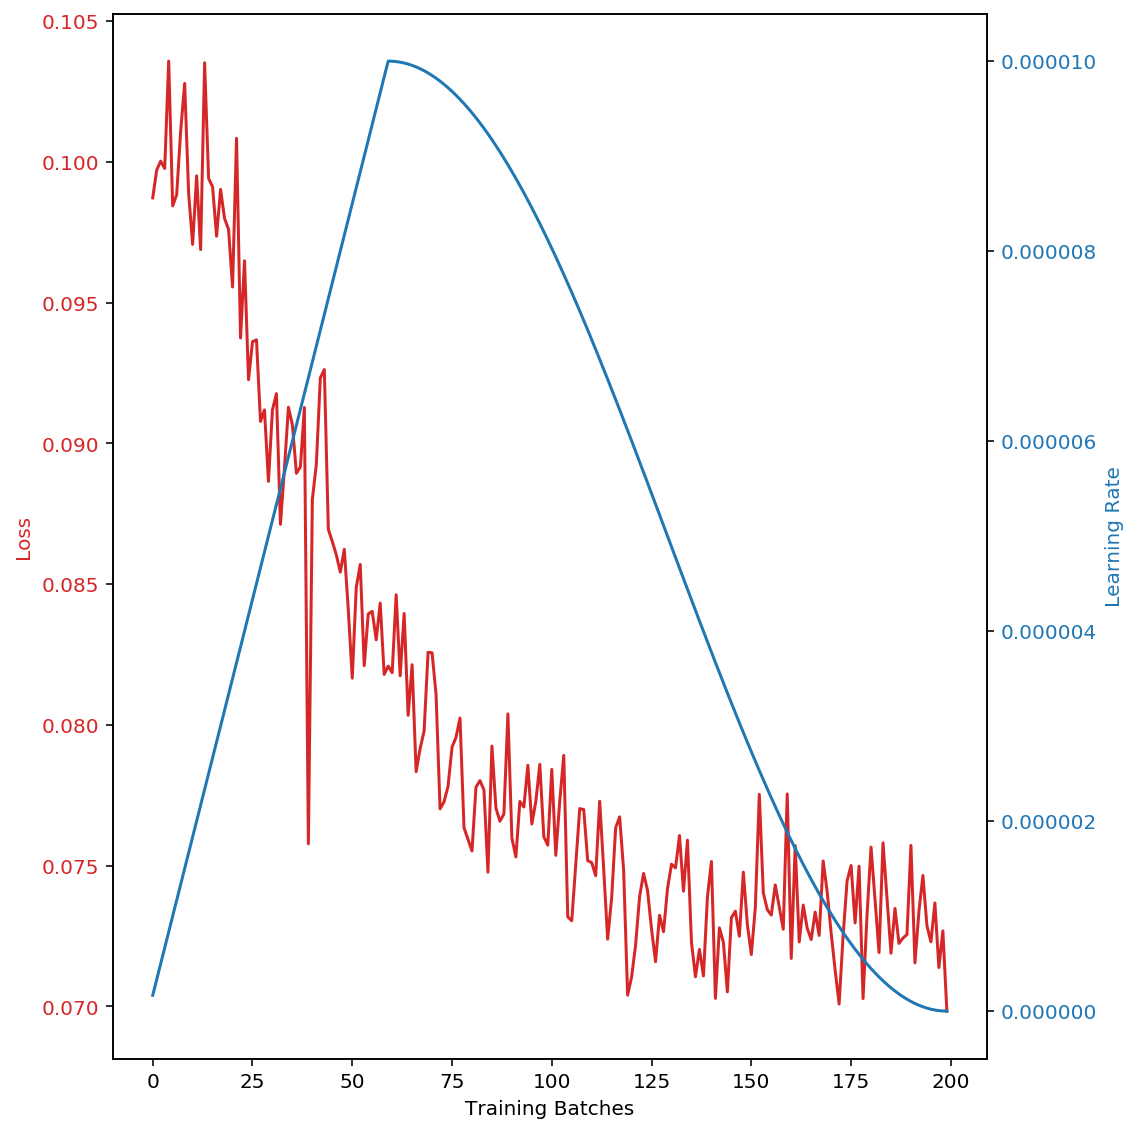

In [22]:
epochs = 5
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(BertVectorizer,
                         dict(sequence_length=88,
                              pooled_multiplier=4,
                              model=output_model + "-cor"), # initial_model
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

model, optim = model_fn()

vectorized_text_processor = np.vectorize(preprocess_text)
def augment_method(texts):
    mask_proba = 0.1
    texts = [random_word_mask(t, model.tokenizer, mask_proba) for t in texts]
    return vectorized_text_processor(texts)


_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 accumulation_steps=1,
                                 plot=True)

# 0.06687


In [23]:
save(model.model, model.tokenizer, output_dir=output_model + "-cor-augsim")


# NSP Style Pretraining

In [27]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random
class DiscriminatoryTextDataset(Dataset):
    def __init__(self, texts, process_text, separator_token):
        self.texts = list(texts)
        self.process_text = process_text
        self.separator_token = separator_token
        
    def __getitem__(self, item):
        process_text = self.process_text
        text = self.texts[item]
        separator_token = self.separator_token
        if random.random() < 0.2:
            if random.random() < 0.5:
                return Sample({"text": text+separator_token+process_text(text), "label": 1})
            else:
                return Sample({"text": process_text(text)+separator_token+text, "label": 1})
        else:
            rt = random.sample(self.texts, 1)[0]
            if random.random() < 0.5:
                return Sample({"text": text+separator_token+process_text(rt), "label": 0})
            else:
                return Sample({"text": process_text(text)+separator_token+rt, "label": 0})
            
    
    def __len__(self):
        return len(self.texts)
    
    

In [28]:
model_name = output_model + "-cor-augsim" # "-augsim"

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params
scheduler_init_fn = get_cosine_schedule_with_warmup()


dataset = DiscriminatoryTextDataset(texts, preprocess_text, f" {tokenizer.sep_token} ")


Pick stored Model /home/ahemf/cache/distilbert-cor-augsim Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.535060 LR = 0.00000333



Epoch =  2 Loss = 0.493070 LR = 0.00000667



Epoch =  3 Loss = 0.448559 LR = 0.00001000



Epoch =  4 Loss = 0.400446 LR = 0.00000950



Epoch =  5 Loss = 0.355031 LR = 0.00000812



Epoch =  6 Loss = 0.316461 LR = 0.00000611



Epoch =  7 Loss = 0.287395 LR = 0.00000389



Epoch =  8 Loss = 0.268461 LR = 0.00000188



Epoch =  9 Loss = 0.257270 LR = 0.00000050



Epoch =  10 Loss = 0.261852 LR = 0.00000000



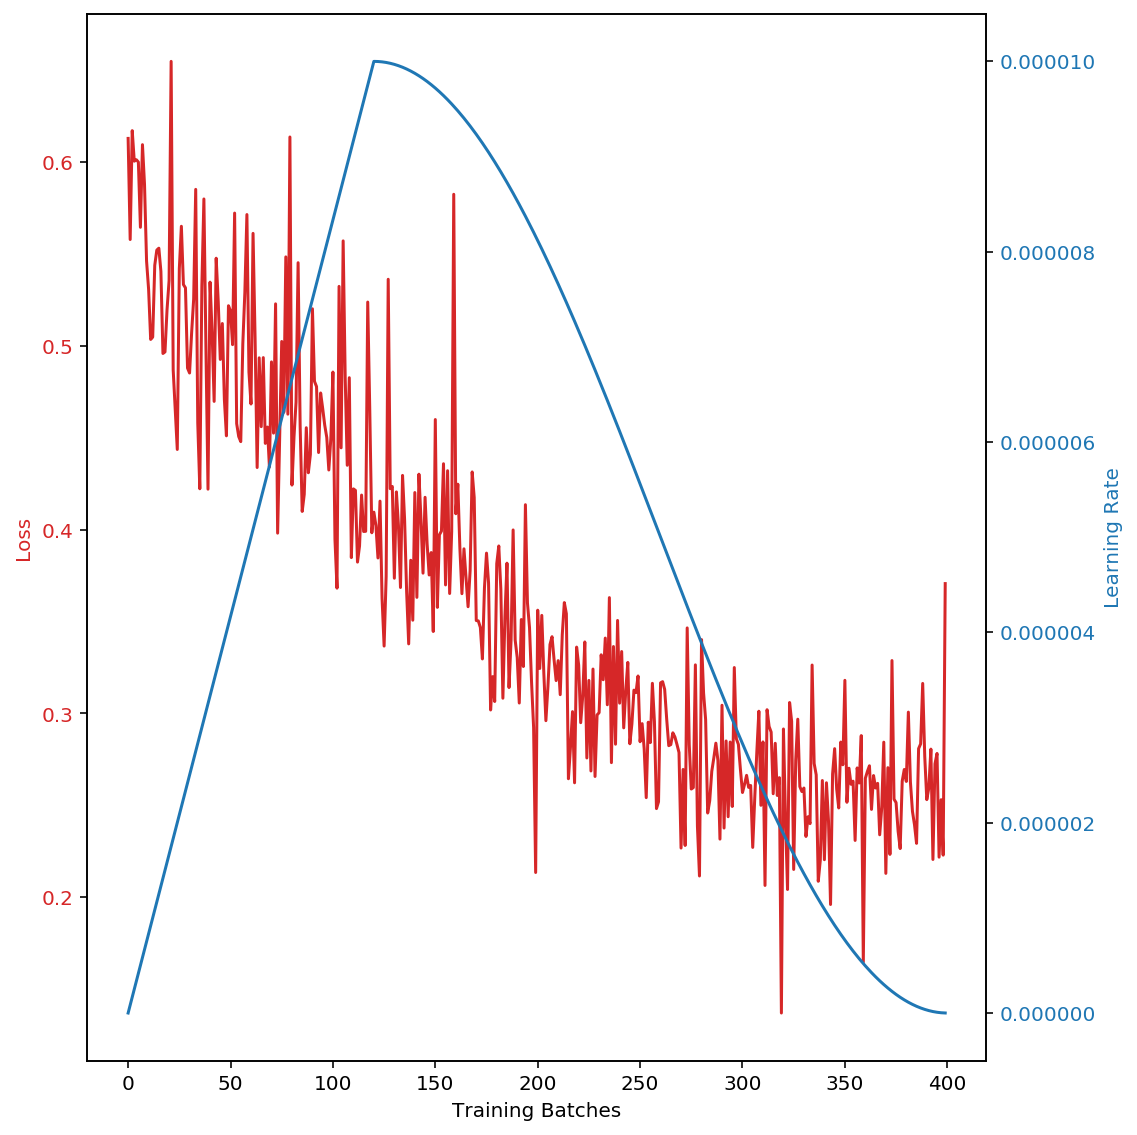

Proba       Preds    
         min   max   min max
Labels                      
0      0.001 0.935     0   1
1      0.013 0.999     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.033,"[0.9668201208114624, 0.03317982703447342]",0,0,0.041,"[0.9587216973304749, 0.04127831012010574]",0,0,0.812,"[0.18817472457885742, 0.8118252158164978]",1,1
1,0.028,"[0.972362220287323, 0.027637720108032227]",0,0,0.049,"[0.9510286450386047, 0.048971354961395264]",0,0,0.052,"[0.9484119415283203, 0.051588043570518494]",0,0
2,0.069,"[0.9313220977783203, 0.06867790222167969]",0,0,0.047,"[0.9531661868095398, 0.0468338206410408]",0,0,0.039,"[0.9605836272239685, 0.03941638767719269]",0,0
3,0.093,"[0.9071890115737915, 0.09281104058027267]",0,0,0.316,"[0.6844354867935181, 0.3155645728111267]",0,1,0.023,"[0.9770007133483887, 0.022999301552772522]",0,0
4,0.161,"[0.8392075896263123, 0.16079244017601013]",0,0,0.053,"[0.9468552470207214, 0.05314474552869797]",0,0,0.161,"[0.8390757441520691, 0.1609242558479309]",0,0


scores =  {'map': '0.9327', 'acc': '0.9408', 'auc': '0.9762'}


([0.9327346819782107, 0.9408, 0.9761963397382356],
 (array([0.94149952, 0.93719212]),
  array([0.98723085, 0.75646123]),
  array([0.96382303, 0.83718372]),
  array([7988, 2012])))

In [29]:

epochs = 10
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=1,
                              n_decoders=0,
                              n_tokens_in=88*2,
                              n_tokens_out=8,
                              featurizer="transformer",
                              model=model_name,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709

model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)



Autocast =  True Epochs =  5 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1



Epoch =  1 Loss = 0.240951 LR = 0.00000067



Epoch =  2 Loss = 0.173462 LR = 0.00000095



Epoch =  3 Loss = 0.123079 LR = 0.00000061



Epoch =  4 Loss = 0.099502 LR = 0.00000019



Epoch =  5 Loss = 0.094497 LR = 0.00000000



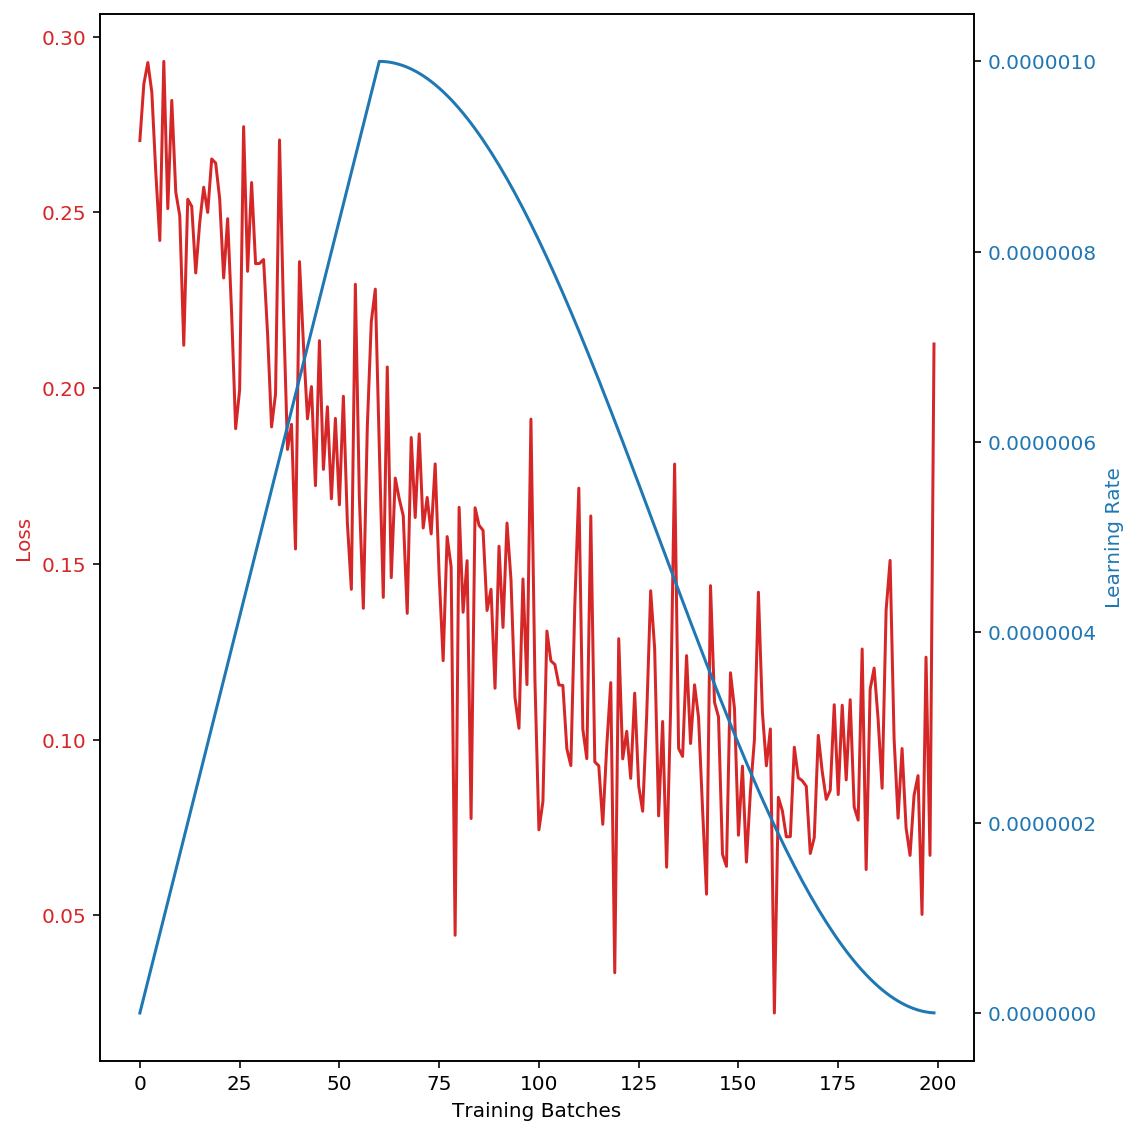

Proba       Preds    
         min   max   min max
Labels                      
0      0.000 1.000     0   1
1      0.009 1.000     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.781,"[0.219045028090477, 0.7809550166130066]",1,1,0.968,"[0.032436151057481766, 0.967563807964325]",1,1,0.007,"[0.9929336309432983, 0.007066401187330484]",0,0
1,0.001,"[0.9988642930984497, 0.0011357826879248023]",0,0,0.005,"[0.9951984286308289, 0.004801641218364239]",0,0,0.004,"[0.9963853359222412, 0.0036146442871540785]",0,0
2,0.008,"[0.991692304611206, 0.008307728916406631]",0,0,0.997,"[0.0029349513351917267, 0.997065007686615]",1,1,0.001,"[0.9990836381912231, 0.0009164002258330584]",0,0
3,0.000,"[0.9995842576026917, 0.00041568942833691835]",0,0,0.031,"[0.9688856601715088, 0.031114377081394196]",0,0,0.000,"[0.9998915195465088, 0.00010847240628208965]",0,0
4,0.001,"[0.9990187883377075, 0.0009811718482524157]",0,0,0.000,"[0.9997331500053406, 0.0002668610541149974]",0,0,0.001,"[0.9990563988685608, 0.0009436192340217531]",0,0


scores =  {'map': '0.9900', 'acc': '0.9824', 'auc': '0.9976'}


([0.9900399422803137, 0.9824, 0.9975919041318952],
 (array([0.98977174, 0.95259708]),
  array([0.98829244, 0.95839675]),
  array([0.98903153, 0.95548811]),
  array([8029, 1971])))

In [30]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}
epochs = 5
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)


In [31]:
save(model.model, model.tokenizer, output_dir=output_model + "-cor-nsp")